In [6]:
pip install gamma-facet

In [5]:
from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (2).csv


In [7]:
import numpy as np
import pandas as pd
from numpy import interp
import matplotlib.pylab as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    auc,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
)
from sklearn.compose import make_column_selector
from sklearn.model_selection import RepeatedKFold

In [8]:
import pandas as pd
import numpy as np
import io
churn_df = pd.read_csv(io.BytesIO(uploaded['WA_Fn-UseC_-Telco-Customer-Churn.csv']))

In [9]:
churn_df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [10]:
from facet.data import Sample
from facet.selection import LearnerRanker, LearnerGrid
from facet.crossfit import LearnerCrossfit

In [11]:
churn_df = churn_df.drop(columns=['customerID'])

# TotalCharges needs to be float (known to have a few missing values)
churn_df.TotalCharges = pd.to_numeric(churn_df.TotalCharges, errors='coerce')

# To support preprocessing pipeline we will also convert SeniorCitizen to object type
# only tenure, MonthlyCharges and TotalCharges are numeric
churn_df.SeniorCitizen = churn_df.SeniorCitizen.astype(str)

# Create a new 0/1 target where 1=churn
churn_df.Churn = churn_df.Churn.map(dict(Yes=1, No=0))

# create sample object
churn_sample = Sample(
    observations=churn_df,
    feature_names=churn_df.drop(columns=["Churn"]).columns,
    target_name="Churn",
)

# check target name
churn_sample.target_name

'Churn'

In [20]:
pip install sklearndf

In [12]:
from sklearn.compose import make_column_selector
from sklearndf.transformation import ColumnTransformerDF
from sklearndf.transformation import SimpleImputerDF
from sklearndf.transformation import OneHotEncoderDF
from sklearndf.pipeline import PipelineDF


from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
from sklearndf.transformation import (
    ColumnTransformerDF,
    OneHotEncoderDF,
    SimpleImputerDF,
)
from sklearndf.transformation.extra import BorutaDF


In [13]:
preprocessing_categorical = PipelineDF(
    steps = [
            ("imputer", SimpleImputerDF(strategy="most_frequent",fill_value="<na>")),
            ("one-hot",OneHotEncoderDF(sparse=False, handle_unknown="ignore")),
    ]
)

preprocessing_numerical = SimpleImputerDF(strategy="median")

In [14]:
preprocessing_features = ColumnTransformerDF(
    transformers = [
                    (
                        "categorcial",
                     preprocessing_categorical,
                     make_column_selector(dtype_include="object")
                    ),
                    (
                        "numerical",
                     preprocessing_numerical,
                     make_column_selector(dtype_include=np.number),
                    ),
    ]
)

In [15]:
boruta_feature_selection = PipelineDF(
    steps=[
        ("preprocessing", preprocessing_features),
        (
            "boruta",
            BorutaDF(
                estimator=RandomForestClassifierDF(
                    max_depth=5, n_jobs=-3, random_state=42
                ),
                n_estimators="auto",
                random_state=42,
                verbose=False,
            ),
        ),
    ]
)

# run feature selection using Boruta and report those selected
boruta_feature_selection.fit(X=churn_sample.features, y=churn_sample.target)
selected = boruta_feature_selection.feature_names_original_.unique()
selected

array(['InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'tenure', 'MonthlyCharges', 'TotalCharges'], dtype=object)

In [16]:
churn_sample_kept_features = churn_sample.keep(feature_names=selected)

In [17]:
rforest_clf = ClassifierPipelineDF(
    preprocessing=preprocessing_features,
    classifier = RandomForestClassifierDF(random_state=42)
)

In [22]:
classifier_grid = [
                   LearnerGrid(
                       pipeline = rforest_clf,
                       learner_parameters={"max_depth": [4, 8], "n_estimators": [200,500]},
                   )
]

In [23]:
clf_ranker = LearnerRanker(
    grids=classifier_grid,
    cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    scoring="roc_auc").fit(churn_sample_kept_features)

In [24]:
clf_ranker.summary_report()

ranking_score   roc_auc  ... classifier             
                        mean  ...  max_depth n_estimators
rank                          ...                        
0         0.825502  0.846088  ...          8          500
1         0.825480  0.845925  ...          8          200
2         0.821349  0.842705  ...          4          200
3         0.820969  0.842484  ...          4          500

[4 rows x 6 columns]

In [25]:
y_pred = clf_ranker.best_model_.predict(churn_sample_kept_features.features)
y_prob = clf_ranker.best_model_.predict_proba(churn_sample_kept_features.features)[1]
y_true = churn_sample_kept_features.target

In [36]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      5174
           1       0.72      0.57      0.63      1869

    accuracy                           0.83      7043
   macro avg       0.79      0.74      0.76      7043
weighted avg       0.82      0.83      0.82      7043



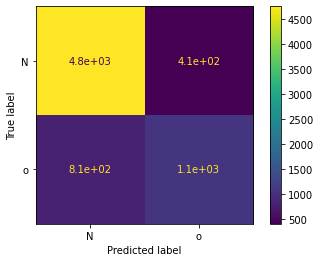

In [40]:
cf_matrix = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cf_matrix,display_labels="None").plot()

In [51]:
prec, recall,s = precision_recall_curve(y_true, y_prob, pos_label=1)


In [56]:
disp = PrecisionRecallDisplay(precision=prec, recall=recall,average_precision="None", estimator_name="None")

ValueError: ignored

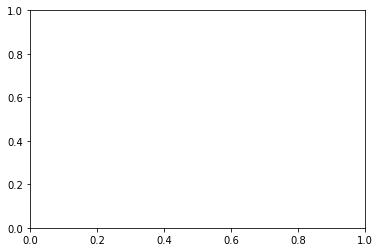

In [57]:
disp.plot()

Text(0.5, 1.0, 'Summary of model performance')

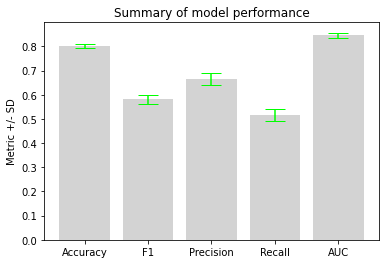

In [58]:
metrics = []

# use established crossfit which contains all splits and fitted models
best_crossfit = clf_ranker.best_model_crossfit_
for (train_index, test_index), model in zip(best_crossfit.splits(), best_crossfit.models()):
    
    # get required target outputs
    y_true = churn_sample_kept_features.target[test_index]
    y_prob = model.predict_proba(churn_sample_kept_features.features.iloc[test_index])[1]
    y_pred = model.predict(churn_sample_kept_features.features.iloc[test_index])
    
    # calculate metrics
    metrics.append(pd.Series({
        'Accuracy': accuracy_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_prob)}))
                   
# collect required summaries and plot
metrics_df = pd.DataFrame(metrics)
fig, ax = plt.subplots()
ax.bar(
    metrics_df.columns,
    metrics_df.mean(),
    yerr=metrics_df.std(),
    align='center',
    ecolor='lime',
    capsize=10,
    color='lightgrey'
)
ax.set_ylabel('Metric +/- SD')
ax.set_title('Summary of model performance')

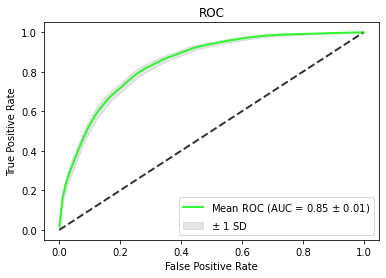

In [59]:
# define plotting function
def roc_plot(fpr, tpr, tpr_std, auc, auc_std):

    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)
    ax.plot(fpr, tpr, color='lime', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (auc, auc_std), lw=2, alpha=.8)
    tpr_upper = np.minimum(tpr + tpr_std, 1)
    tpr_lower = np.maximum(tpr - tpr_std, 0)
    ax.fill_between(fpr, tpr_lower, tpr_upper, color='grey', alpha=.2, label=r'$\pm$ 1 SD')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC')
    ax.legend(loc='lower right')
    plt.show()
    
# some set-up
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# use established crossfit which contains all splits and fitted models
best_crossfit = clf_ranker.best_model_crossfit_
for (train_index, test_index), model in zip(best_crossfit.splits(), best_crossfit.models()):
    
    # predict probability for a splits test set using the fitted model
    prediction = model.predict_proba(churn_sample_kept_features.features.iloc[test_index])
    
    # calculate roc curve and interpolate true positive rate
    fpr, tpr, t = roc_curve(churn_sample_kept_features.target[test_index], prediction[1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    
    # calculate AUC
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

# collect required summaries
auc_mean, auc_std = np.mean(aucs), np.std(aucs)
mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)

# create plot
roc_plot(mean_fpr, mean_tpr, std_tpr, auc_mean, auc_std)
